# Segmentez des clients d'un site e-commerce
Nous sommes consultants pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne. Olist souhaite que nous fournissions à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. </br>
L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles, fournir à l’équipe marketing une description actionable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale, et proposer un contrat de maintenance basé sur une analyse de la stabilité des segments au cours du temps.

# Sommaire :
- **Partie 1:** <a href="#C1">Importation des données</a>
- **Partie 2:** <a href="#C2">Union des jeux de données</a>
- **Partie 3:** <a href="#C3">Nettoyage du jeu de données</a>
    - <a href="#C4">Typage des variables</a>
    - <a href="#C5">Valeurs manquantes</a>
    - <a href="#C6">Doublons</a>
    - <a href="#C7">Détection d'Outliers</a>
- **Partie 4:** <a href="#C8">Feature Engineering</a>
    - <a href="#C9">Délai de livraison</a>
    - <a href="#C10">Traduction des catégories</a>
    - <a href="#C11">Nombre de commandes par client</a>
    - <a href="#C12">Sélection des variables pertinentes</a>
- **Partie 5:** <a href="#C13">Exploration des données</a>
    - <a href="#C14">Analyse univariée</a>
    - <a href="#C15">Analyse bivariée</a>
    - <a href="#C16">Réduction dimensionnelle</a>
- **Partie 6:** <a href="#C17">Exportation du jeu de données</a>

# <a name="C1">Partie 1: Importation des données </a>
Importons tout d'abord les librairies utiles pour le nettoyage et l'exploration des données.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pd.set_option('display.max_columns', 100)

On peut à présent charger les jeux de données.

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv', sep=',',encoding='utf-8')
geolocation = pd.read_csv('olist_geolocation_dataset.csv', sep=',',encoding='utf-8')
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',',encoding='utf-8')
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',',encoding='utf-8')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',',encoding='utf-8')
orders = pd.read_csv('olist_orders_dataset.csv', sep=',',encoding='utf-8')
products = pd.read_csv('olist_products_dataset.csv', sep=',',encoding='utf-8')
sellers = pd.read_csv('olist_sellers_dataset.csv', sep=',',encoding='utf-8')
product_category_name_translation = pd.read_csv('product_category_name_translation.csv', sep=',',encoding='utf-8')

# <a name="C2">Partie 2: Union des Jeux de données</a>
La difficulté ici est que les données sont contenues dans différentes bases de données. Pour répondre à notre problématique, nous allons devoir commencer par trier et sélectionner les variables utilies puis les regrouper en un seul jeu de données exploitable. On pourra pour cela s'appuyer sur le schéma de relations des tables ci-dessous.

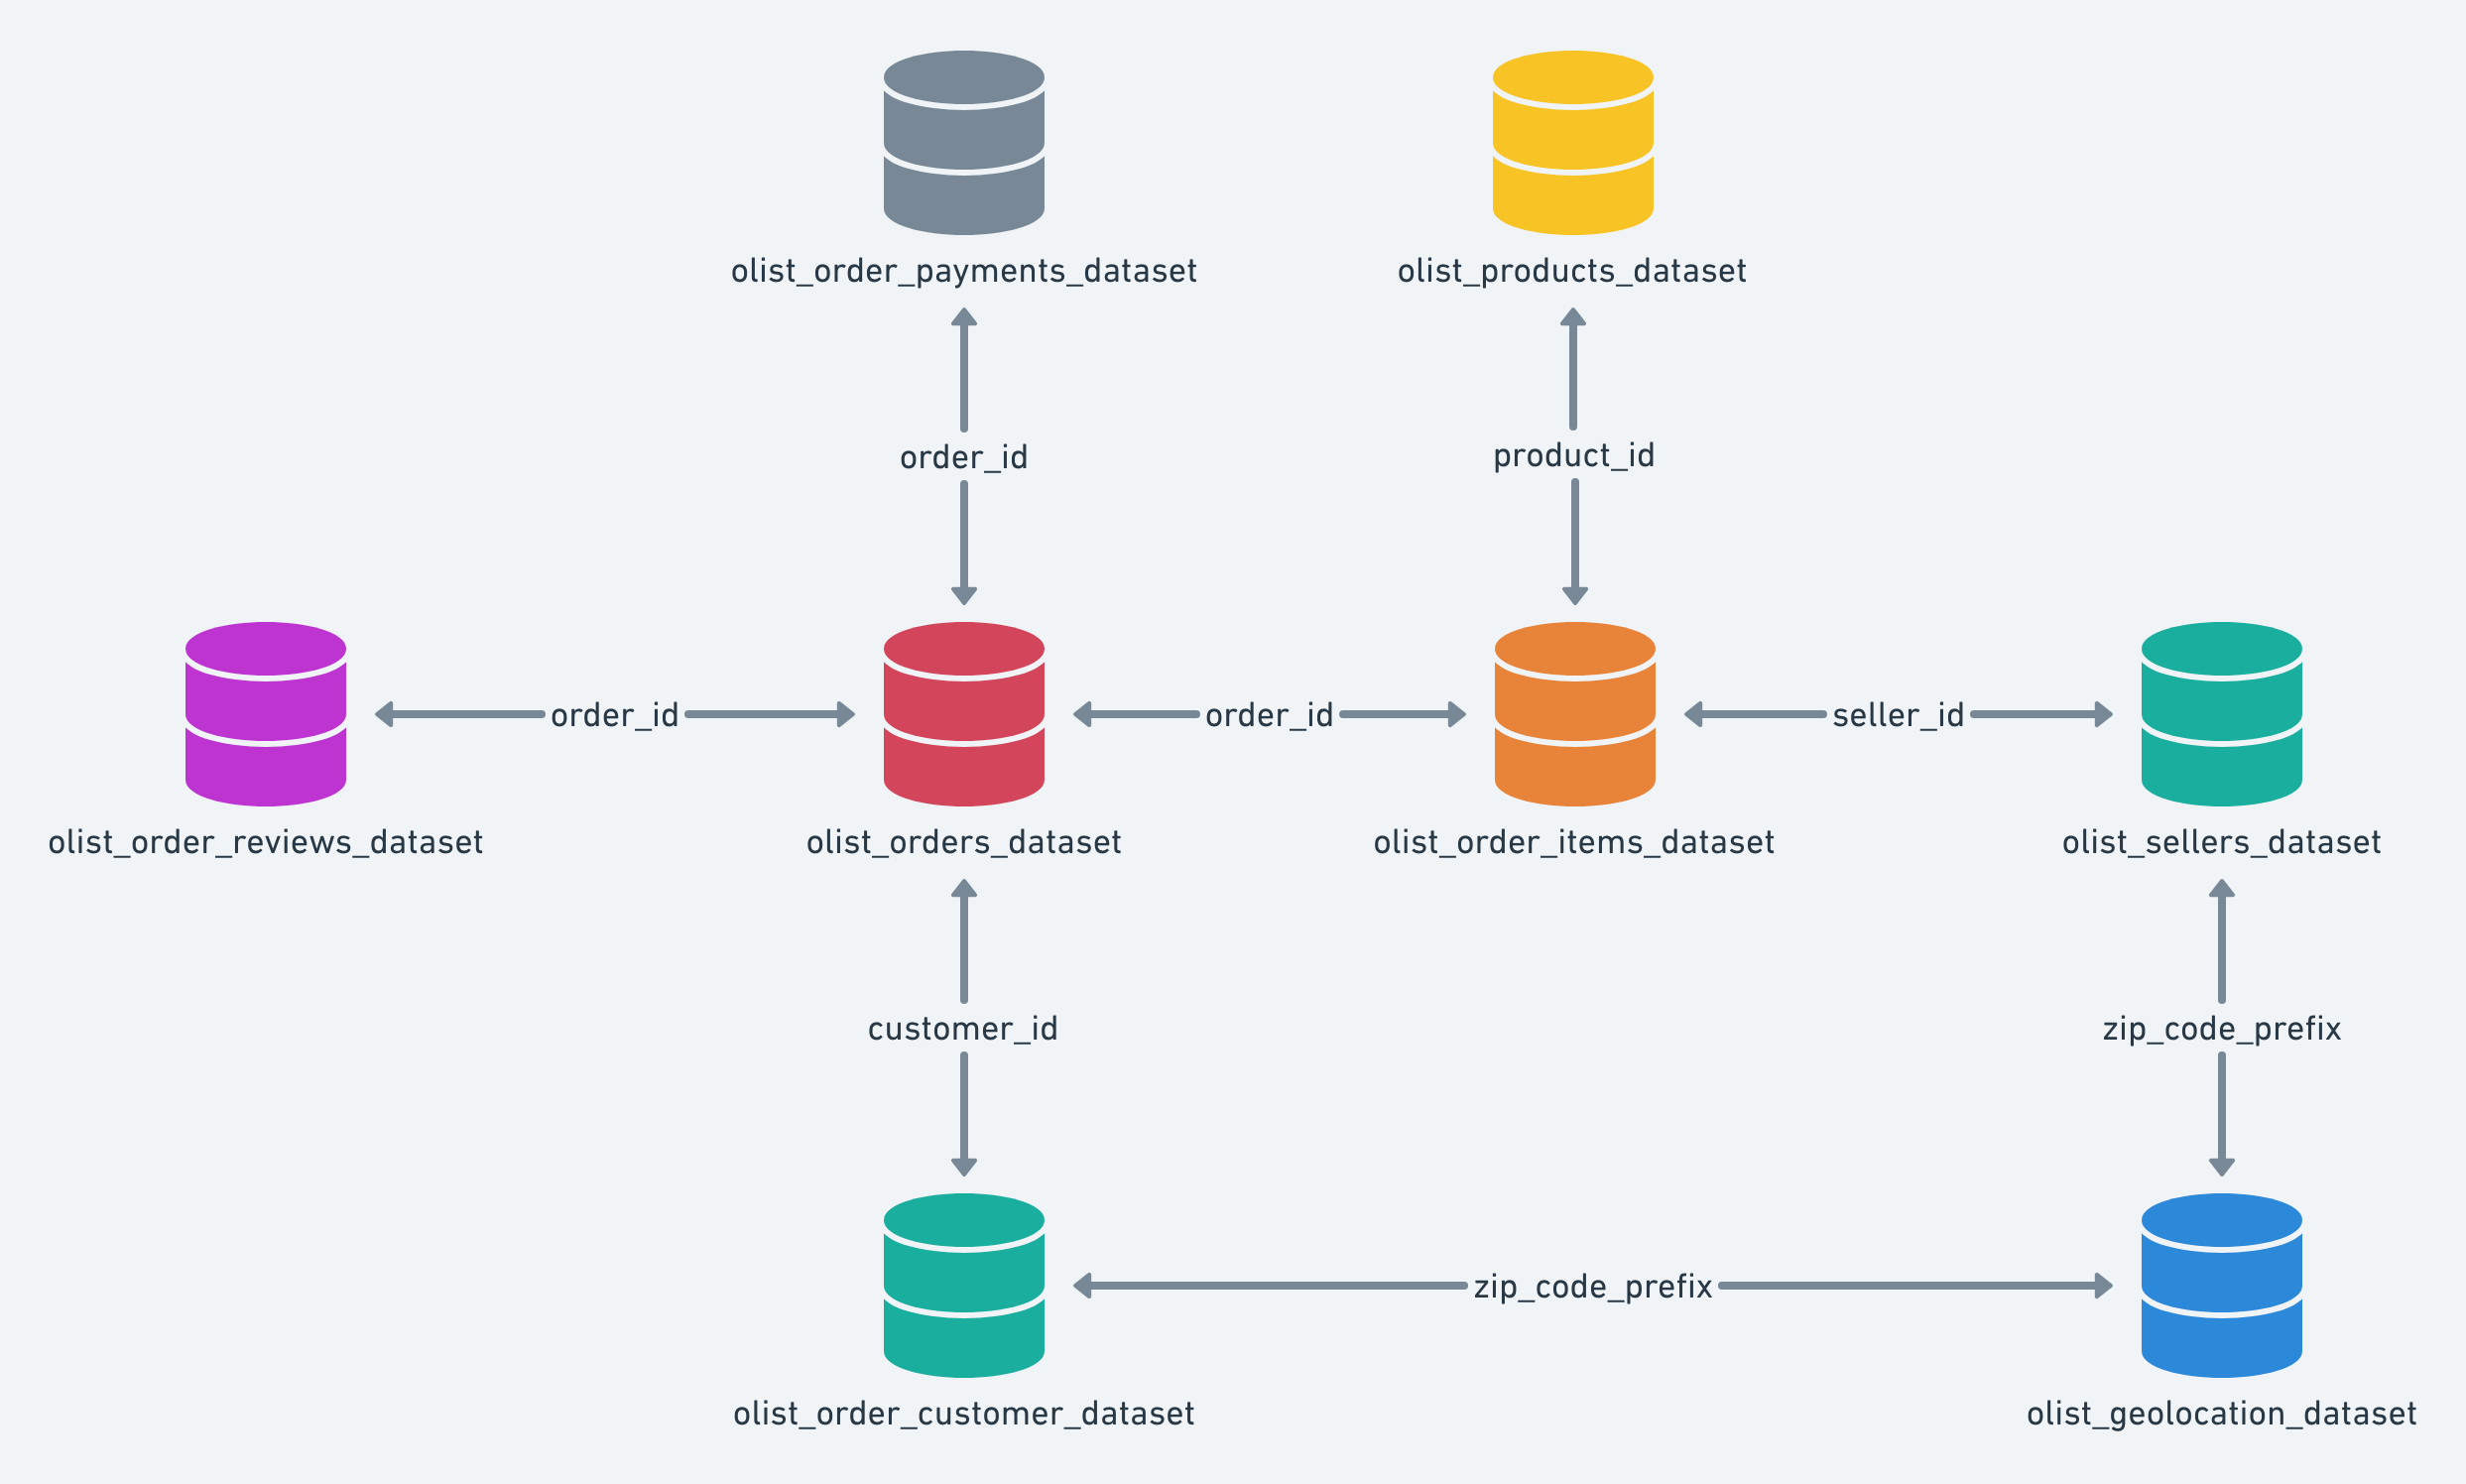

In [4]:
data = customers
data = data.merge(orders, on='customer_id', how='left')
data = data.merge(order_reviews, on='order_id', how='left')
data = data.merge(order_items, on='order_id', how='left')
data = data.merge(order_payments, on='order_id', how='left')
data = data.merge(products, on='product_id', how='left')
data = data.merge(sellers, on='seller_id', how='left')
data = data.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,14409.0,-20.509897,-47.397866,franca,SP
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,14409.0,-20.497396,-47.399241,franca,SP
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,14409.0,-20.510459,-47.399553,franca,SP
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,14409.0,-20.480940,-47.394161,franca,SP
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,88b8b52d46df026a9d1ad2136a59b30b,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,14409.0,-20.515413,-47.398194,franca,SP


On peut maintenant faire un peu de ménage et supprimer les variables inutiles.

In [5]:
listeVar = ['customer_id', 'customer_zip_code_prefix', 'review_id', 'order_item_id', 'product_id', 'geolocation_city', 
           'geolocation_state', 'geolocation_zip_code_prefix']
data.drop(listeVar, axis=1, inplace=True)

# <a name="C3">Partie 3: Nettoyage du jeu de données</a>
Le jeu de données étant maintenant formé il nous faut le contrôler et le nettoyer avant de pouvoir l'exploiter.
## <a name="C4">3.1: Typage des variables</a>
Commençons par contrôler le type des variables

In [6]:
data.dtypes

customer_unique_id                object
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp           object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
product_category_name             object
product_name_len

On va modifier le typage des dates.

In [7]:
listeVarDates = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                 'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_creation_date', 
                 'review_answer_timestamp', 'shipping_limit_date']

for var in listeVarDates:
    data[var] = pd.to_datetime(data[var])
    
data.dtypes

customer_unique_id                       object
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_score                            float64
review_comment_title                     object
review_comment_message                   object
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
payment_sequential                      float64
payment_type                            

## <a name="C5">3.2: Valeurs manquantes</a>
On s'intéresse à présent aux valeurs manquantes et à leur implémentation.

In [8]:
def quantite_valeurs_manquantes(data):
    """fonction permettant d'obtenir le nombre et le pourcentage de valeurs manquantes pour chaque variable d'un dataframe, 
    dans l'ordre décroissant"""
    
    valeurs = data.isnull().sum()
    pourcentage = 100 * data.isnull().sum() / len(data)
    table = pd.concat([valeurs, pourcentage.round(2)], axis=1)
    table.columns = ['Nombre de valeurs manquantes', '% de valeurs manquantes']
    
    return table[table['Nombre de valeurs manquantes'] != 0].sort_values('% de valeurs manquantes', ascending = False).style.background_gradient('OrRd')

In [9]:
quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes
review_comment_title,16154810,88.820000
review_comment_message,10703692,58.850000
order_delivered_customer_date,496943,2.730000
product_category_name,385842,2.120000
product_photos_qty,385842,2.120000
product_description_lenght,385842,2.120000
product_name_lenght,385842,2.120000
order_delivered_carrier_date,318246,1.750000
review_score,143939,0.790000
review_creation_date,143939,0.790000


La variable `review_comment_title` contient trop de valeurs manquantes et ne semble pas pertinente pour notre problématique de segmentation. On va donc la supprimer. </br>
Les valeurs manquantes de la variable `review_comment_message` correspondent à des acheteurs n'ayant laisser aucun commentaire. On peut alors compléter les valeurs manquantes par la mention **No comment**.

In [10]:
data.drop('review_comment_title', axis=1, inplace=True)
data['review_comment_message'].fillna('No Comment', inplace=True)

In [11]:
quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes
order_delivered_customer_date,496943,2.730000
product_photos_qty,385842,2.120000
product_description_lenght,385842,2.120000
product_name_lenght,385842,2.120000
product_category_name,385842,2.120000
order_delivered_carrier_date,318246,1.750000
review_score,143939,0.790000
review_creation_date,143939,0.790000
review_answer_timestamp,143939,0.790000
product_height_cm,128375,0.710000


Pour les variables quantitatives, on va remplacer les valeurs manquantes par la valeur moyenne. Le pourcentage de valeurs manquantes étant faible et la quantité de données importante, la moyenne empirique est proche de sa valeur vraie.

In [12]:
listeVarQuanti = ['payment_installments', 'payment_sequential', 'payment_value', 'freight_value', 'price', 
                  'product_width_cm', 'product_height_cm', 'product_weight_g', 'product_length_cm', 'review_score',
                 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'geolocation_lat', 
                 'geolocation_lng']

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(data[listeVarQuanti])

data[listeVarQuanti] = imputer.transform(data[listeVarQuanti])

quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes
order_delivered_customer_date,496943,2.730000
product_category_name,385842,2.120000
order_delivered_carrier_date,318246,1.750000
review_creation_date,143939,0.790000
review_answer_timestamp,143939,0.790000
seller_id,124697,0.690000
shipping_limit_date,124697,0.690000
seller_zip_code_prefix,124697,0.690000
seller_city,124697,0.690000
seller_state,124697,0.690000


Pour les variables qualitatives, on va remplacer les valeurs manquantes par la valeur la plus fréquente. A nouveau, les pourcentages de valeurs manquantes n'étant pas trop élevés, on ne risque pas de créer une erreur trop importante.

In [13]:
listeVarQuali = ['payment_type', 'seller_state', 'seller_city', 'seller_zip_code_prefix', 'seller_id', 
                 'product_category_name']

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
imputer = imputer.fit(data[listeVarQuali])

data[listeVarQuali] = imputer.transform(data[listeVarQuali])

quantite_valeurs_manquantes(data)

,Nombre de valeurs manquantes,% de valeurs manquantes
order_delivered_customer_date,496943,2.730000
order_delivered_carrier_date,318246,1.750000
review_creation_date,143939,0.790000
review_answer_timestamp,143939,0.790000
shipping_limit_date,124697,0.690000
order_approved_at,27290,0.150000


La variable `order_delivered_customer_date` nous servira à calculer par la suite le délai de livraison d'une commande. On remplacera alors à ce moment-là les valeurs manquantes par le délai moyen. </br>
Les autres valeurs manquantes semblent difficiles à estimer. De plus, ce ne sont pas des variables qui semblent à première vue utilies pour la segmentation. On va donc les laisser ainsi pour le moment.

## <a name="C6">3.3: Doublons</a>
Contrôlons à présent si une même commande n'a pas été renseignée plusieurs fois.

In [14]:
data.loc[data.duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
9,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.513713,-47.396644
48,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.497904,-47.405578
55,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.513713,-47.396644
57,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.479901,-47.397403
59,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.509746,-47.393731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18188940,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,1.0,credit_card,1.0,21.77,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.594582,-46.907318
18188946,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,1.0,credit_card,1.0,21.77,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.593740,-46.909114
18188952,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou 

Il y a un certains nombres de lignes identiques. Supprimons-les.

In [15]:
data.drop_duplicates(inplace=True, ignore_index=True)
data.loc[data.duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng


Plus aucune ligne n'est identique à une autre, mais cela ne garantit pas l'abscence de doublons. On peut vérifier qu'il n'y a pas de doublons au niveau des identifiants de commande.

In [16]:
data.loc[data['order_id'].duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
1,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.497396,-47.399241
2,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.510459,-47.399553
3,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.480940,-47.394161
4,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.515413,-47.398194
5,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.513713,-47.396644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11006960,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,1.0,credit_card,1.0,21.77,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.598092,-46.904582
11006961,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,1.0,credit_card,1.0,21.77,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.594171,-46.908091
11006962,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem 

In [17]:
data[data['order_id'] == '17825f24877a9289214c301ae0c9424b']

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng
2473,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,2.0,voucher,1.0,34.05,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.555015,-46.692274
2474,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,2.0,voucher,1.0,34.05,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.553535,-46.693238
2475,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,2.0,voucher,1.0,34.05,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.557069,-46.690816
2476,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,2.0,voucher,1.0,34.05,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.562772,-46.686697
2477,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,2.0,voucher,1.0,34.05,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.565848,-46.684588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,1.0,credit_card,1.0,67.98,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.561480,-46.687686
2571,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,1.0,credit_card,1.0,67.98,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.555121,-46.692137
2572,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,1.0,credit_card,1.0,67.98,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.554389,-46.692717
2573,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17

On se rend compte qu'il ne s'agit pas (que) de doublons mais de commandes payées en plusieurs fois. On va donc les agréger en une seule commande.

In [18]:
gb = data.groupby('order_id').agg(
                                payment_sequential = ('payment_sequential', max),
                                payment_type = ('payment_type', max),
                                payment_installments = ('payment_installments', max),
                                payment_value = ('payment_value', sum)
                                )
gb

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,1.0,credit_card,2.0,8229.66
00018f77f2f0320c557190d7a144bdd3,1.0,credit_card,3.0,78728.49
000229ec398224ef6ca0657da4fc703e,1.0,credit_card,5.0,41205.30
00024acbcdf0a6daa1e931b038114c75,1.0,credit_card,2.0,438.26
00042b26cf59d7ce69dfabb4e55b4fd9,1.0,credit_card,3.0,872.16
...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,1.0,boleto,1.0,15796.40
fffcd46ef2263f404302a634eb57f7eb,1.0,boleto,1.0,2319.18
fffce4705a9662cd70adb13d4a31832d,1.0,credit_card,3.0,2921.25


In [19]:
data.drop(['payment_sequential', 'payment_type', 'payment_installments', 'payment_value'], axis=1, inplace=True)
data = data.merge(gb, on='order_id', how='left')

On contrôle et supprime à nouveau les lignes en doubles.

In [20]:
data.loc[data.duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value
2524,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.555015,-46.692274,2.0,voucher,1.0,5203.53
2525,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.553535,-46.693238,2.0,voucher,1.0,5203.53
2526,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.557069,-46.690816,2.0,voucher,1.0,5203.53
2527,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.562772,-46.686697,2.0,voucher,1.0,5203.53
2528,7f3a72e8f988c6e735ba118d54f47458,sao paulo,SP,17825f24877a9289214c301ae0c9424b,delivered,2017-05-11 13:48:47,2017-05-13 11:55:16,2017-05-15 15:30:02,2017-06-07 12:02:14,2017-05-30,4.013674,No Comment,NaT,NaT,4a3ca9315b744ce9f8e9374361493884,2017-05-19 11:55:16,89.9,12.13,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,14940.0,ibitinga,SP,-23.565848,-46.684588,2.0,voucher,1.0,5203.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11005768,e7f8760e2bbd2f1986bebd99596c088e,belem,PA,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2017-03-15 21:04:08,2017-03-20 08:34:12,2017-04-05 11:07:12,2017-04-26,3.000000,No Comment,2017-04-06,2017-04-06 21:42:14,bf0045791395e66460eb04749c68672a,2017-03-28 21:04:08,59.9,24.42,papelaria,62.0,621.0,1.0,600.0,16.0,6.0,11.0,4256.0,sao paulo,SP,-1.469083,-48.487346,2.0,voucher,1.0,9022.24
11005769,e7f8760e2bbd2f1986bebd99596c088e,belem,PA,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2017-03-15 21:04:08,2017-03-20 08:34:12,2017-04-05 11:07:12,2017-04-26,3.000000,No Comment,2017-04-06,2017-04-06 21:42:14,bf0045791395e66460eb04749c68672a,2017-03-28 21:04:08,59.9,24.42,papelaria,62.0,621.0,1.0,600.0,16.0,6.0,11.0,4256.0,sao paulo,SP,-1.465250,-48.485992,2.0,voucher,1.0,9022.24
11005770,e7f8760e2bbd2f1986bebd99596c088e,belem,PA,ec3a75fb0ac595e461765d2d854b1d08,delivered,2017-03-15 21:04:08,2017-03-15 21:04:08,2017-03-20 08:34:12,2017-04-05 11:07:12,2017-04-26,3.000000,No Comment,2017-04-06,2017-04-06 21:42:14,bf0045791395e66460eb04749c68672a,2017-03-28 21:04:08,59.9,24.42,papelaria,62.0,621.0,1.0,600.0,16.0,6.0,11.0,4256.0,sao paulo,SP,-1.454873,-48.492256,2.0,voucher,1.0,9022.24
1100577

In [21]:
data.drop_duplicates(inplace=True, ignore_index=True)
data.loc[data.duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value


In [22]:
data.loc[data['order_id'].duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value
1,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.497396,-47.399241,1.0,credit_card,2.0,18505.62
2,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.510459,-47.399553,1.0,credit_card,2.0,18505.62
3,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.480940,-47.394161,1.0,credit_card,2.0,18505.62
4,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.515413,-47.398194,1.0,credit_card,2.0,18505.62
5,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.513713,-47.396644,1.0,credit_card,2.0,18505.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10521980,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.598092,-46.904582,1.0,credit_card,1.0,2351.16
10521981,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produto chegou bem antes do prazo , gostei mui...",2017-12-27,2017-12-27 23:21:06,3c7c4a49ec3c6550809089c6a2ca9370,2017-12-26 18:50:39,13.99,7.78,perfumaria,54.0,933.0,1.0,50.0,16.0,5.0,11.0,3804.0,sao paulo,SP,-23.594171,-46.908091,1.0,credit_card,1.0,2351.16
10521982,84732c5050c01db9b23e19ba39899398,cotia,SP,28db69209a75e59f20ccbb5c36a20b90,delivered,2017-12-19 14:27:23,2017-12-19 18:50:39,2017-12-21 19:17:21,2017-12-26 18:42:36,2018-01-08,5.0,"Produ

En regardant d'un peu plus près les doublons on remarque que les seules différences concernent les prix, les dimensions, les latitudes ou longitudes, ou bien des commentaires modifiés à posteriori. On va donc considérer qu'il s'agit bien de doublons avec de légères erreurs de saisie et supprimer les répétitions.

In [23]:
data.drop_duplicates(subset=['order_id'], inplace=True, ignore_index=True)
data.loc[data['order_id'].duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value


## <a name="C7">3.4:Détection d'Outliers</a>
Un describe peut potentiellement nous aider dans un premier temps.

In [24]:
data.describe()

,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,geolocation_lat,geolocation_lng,payment_sequential,payment_installments,payment_value
count,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,9.944100e+04
mean,4.086287,125.928678,20.197259,48.842180,793.826712,2.249296,2102.983567,30.109814,16.489669,23.026739,-21.195110,-46.175546,1.045515,2.930521,1.749905e+04
std,1.342090,190.628316,15.847841,9.888507,647.502414,1.727762,3750.679491,16.065006,13.272614,11.695782,5.612873,4.060532,0.382175,2.715671,4.207096e+04
min,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,-36.605374,-72.666706,1.000000,0.000000,0.000000e+00
25%,4.000000,42.000000,13.370000,43.000000,354.000000,1.000000,300.000000,18.000000,8.000000,15.000000,-23.587597,-48.083034,1.000000,1.000000,3.138520e+03
50%,5.000000,79.900000,16.440000,51.000000,620.000000,2.000000,700.000000,25.000000,13.000000,20.000000,-22.925319,-46.629081,1.000000,2.000000,7.463850e+03
75%,5.000000,139.890000,21.180000,57.000000,982.000000,3.000000,1850.000000,38.000000,20.000000,30.000000,-20.147537,-43.613084,1.000000,4.000000,1.749120e+04
max,5.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,42.184003,-8.577855,29.000000,24.000000,3.687948e+06


Tout d'abord, toutes les grandeurs quantitatives sont comprises entre un minimum et un maximum raisonnables. Plus particulièrement, toutes les quantités minimales sont positives ou nulles, ce qui est rassurant dans notre cas. La plus petit montant payé est égal à 0 Réal Brésiline (R$) ce qui semble un peu étrange. Regardons cela de plus près.

In [25]:
data[data['payment_value'] == 0]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value
3742,968fac81e2c44fb6c1e3ac2a45e6a102,sao paulo,SP,4637ca194b6387e2d538dc89b124b0ee,canceled,2018-09-03 14:14:25,NaT,NaT,NaT,2018-09-10,3.0,Recebi o Diario do Bebê c um pequeno rasgo na ...,2018-08-17,2018-08-18 15:32:40,4a3ca9315b744ce9f8e9374361493884,NaT,121.390196,19.602953,cama_mesa_banho,48.65549,778.971294,2.191815,2148.626927,30.477873,16.694334,23.14662,14940.0,sao paulo,SP,-23.673153,-46.686683,1.0,not_defined,1.0,0.0
48774,4fa4365000c7090fcb8cad5713c6d3db,sao paulo,SP,00b1cb0320190ca0daa2c88b35206009,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,1.0,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28,2018-08-28 18:25:55,4a3ca9315b744ce9f8e9374361493884,NaT,121.390196,19.602953,cama_mesa_banho,48.65549,778.971294,2.191815,2148.626927,30.477873,16.694334,23.14662,14940.0,sao paulo,SP,-23.527788,-46.660310,1.0,not_defined,1.0,0.0
62999,6ba987d564bad1f9da8e14b9d3b71c8f,sao paulo,SP,c8c528189310eaa44a745b8d9d26908b,canceled,2018-08-28 20:05:14,NaT,NaT,NaT,2018-09-11,1.0,No Comment,2018-08-24,2018-08-25 02:24:54,4a3ca9315b744ce9f8e9374361493884,NaT,121.390196,19.602953,cama_mesa_banho,48.65549,778.971294,2.191815,2148.626927,30.477873,16.694334,23.14662,14940.0,sao paulo,SP,-23.508092,-46.432200,1.0,not_defined,1.0,0.0


Il s'agit de commandes qui ont été annulées, d'où un montant de 0 R$. </br>
On ne va conserver que les commandes qui ont bien été délivrées.

In [26]:
data = data[data['order_status'] == 'delivered']
data.head()

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.509897,-47.397866,1.0,credit_card,2.0,18505.62
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,5.0,No Comment,2018-01-30,2018-02-10 22:43:29,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,-23.726853,-46.545746,1.0,credit_card,8.0,39922.12
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,5.0,No Comment,2018-06-15,2018-06-15 12:10:59,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,-23.527788,-46.660310,1.0,credit_card,7.0,4258.71
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,5.0,No Comment,2018-03-29,2018-04-02 18:36:47,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,-23.496930,-46.185352,1.0,credit_card,1.0,14383.90
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,5.0,O baratheon è esxelente Amo adoro o baratheon,2018-08-10,2018-08-17 01:59:52,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,-22.987222,-47.151073,1.0,credit_card,8.0,33044.75


# <a name="C8">Partie 4: Feature Engineering</a>
Maintenant que le nettoyage du jeu de données est terminé et avant de se lancer dans son exploration, on va repérer et préparer les caractéristiques intéressantes pour les modèles de prédiction.
## <a name="C9">4.1: Délai de livraison</a>
On va commencer par calculer les délais de livraison réel et estimé des commandes en utilisant les variables `order_purchase_timestamp`, `order_delivered_customer_date` et `order_estimated_delivery_date`

In [27]:
#Délai de livraison réel
data['delivery_time'] = data['order_delivered_customer_date'] - data['order_purchase_timestamp']
data.head()

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value,delivery_time
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.509897,-47.397866,1.0,credit_card,2.0,18505.62,8 days 19:30:00
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,5.0,No Comment,2018-01-30,2018-02-10 22:43:29,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,-23.726853,-46.545746,1.0,credit_card,8.0,39922.12,16 days 15:52:55
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,5.0,No Comment,2018-06-15,2018-06-15 12:10:59,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,-23.527788,-46.660310,1.0,credit_card,7.0,4258.71,26 days 01:51:06
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,5.0,No Comment,2018-03-29,2018-04-02 18:36:47,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,-23.496930,-46.185352,1.0,credit_card,1.0,14383.90,14 days 23:57:47
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,5.0,O baratheon è esxelente Amo adoro o baratheon,2018-08-10,2018-08-17 01:59:52,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,-22.987222,-47.151073,1.0,credit_card,8.0,33044.75,11 days 11:04:18


On regarde s'il y a des valeurs manquantes pour les commandes qui ont bien été livrées. Si oui, on les remplace par le délai de livraison moyen.

In [28]:
data['delivery_time'].isnull().sum()

8

In [29]:
data['delivery_time'] = (data['delivery_time']).fillna(data['delivery_time'].mean())

In [30]:
data['delivery_time'].isnull().sum()

0

In [31]:
#Délai de livraison estimé
data['estimated_delivery_time'] = data['order_estimated_delivery_date'] - data['order_purchase_timestamp']
data.head()

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value,delivery_time,estimated_delivery_time
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.509897,-47.397866,1.0,credit_card,2.0,18505.62,8 days 19:30:00,19 days 08:54:25
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,5.0,No Comment,2018-01-30,2018-02-10 22:43:29,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,-23.726853,-46.545746,1.0,credit_card,8.0,39922.12,16 days 15:52:55,24 days 03:11:36
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,5.0,No Comment,2018-06-15,2018-06-15 12:10:59,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,-23.527788,-46.660310,1.0,credit_card,7.0,4258.71,26 days 01:51:06,24 days 07:52:15
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,5.0,No Comment,2018-03-29,2018-04-02 18:36:47,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,-23.496930,-46.185352,1.0,credit_card,1.0,14383.90,14 days 23:57:47,27 days 07:53:22
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,5.0,O baratheon è esxelente Amo adoro o baratheon,2018-08-10,2018-08-17 01:59:52,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,-22.987222,-47.151073,1.0,credit_card,8.0,33044.75,11 days 11:04:18,16 days 14:08:30


In [32]:
#On regarde s'il y a des valeurs manquantes
data['estimated_delivery_time'].isnull().sum()

0

Pour en faciliter l'utilisation on ne va garder que la durée en jours.

In [33]:
def livraisonJours(delai):
    """Fonction qui récupère seulement le nombre de jours de livraison"""
    
    return delai.days

In [34]:
data['delivery_time'] = data['delivery_time'].apply(livraisonJours)
data['estimated_delivery_time'] = data['estimated_delivery_time'].apply(livraisonJours)
data.head()

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value,delivery_time,estimated_delivery_time
0,861eff4711a542e4b93843c6dd7febb0,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,No Comment,2017-05-26,2017-05-30 22:34:40,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,-20.509897,-47.397866,1.0,credit_card,2.0,18505.62,8,19
1,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,5.0,No Comment,2018-01-30,2018-02-10 22:43:29,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,88303.0,itajai,SC,-23.726853,-46.545746,1.0,credit_card,8.0,39922.12,16,24
2,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,5.0,No Comment,2018-06-15,2018-06-15 12:10:59,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,8577.0,itaquaquecetuba,SP,-23.527788,-46.660310,1.0,credit_card,7.0,4258.71,26,24
3,259dac757896d24d7702b9acbbff3f3c,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,5.0,No Comment,2018-03-29,2018-04-02 18:36:47,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,8577.0,itaquaquecetuba,SP,-23.496930,-46.185352,1.0,credit_card,1.0,14383.90,14,27
4,345ecd01c38d18a9036ed96c73b8d066,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,5.0,O baratheon è esxelente Amo adoro o baratheon,2018-08-10,2018-08-17 01:59:52,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,14940.0,ibitinga,SP,-22.987222,-47.151073,1.0,credit_card,8.0,33044.75,11,16


## <a name="C10">4.2: Traduction des catégories</a>
Pour faciliter la compréhension et l'exploitation des données, on va traduire le nom des catégories.

In [35]:
product_category_name_translation.set_index('product_category_name',drop=True).T.to_dict('records')[0]

{'beleza_saude': 'health_beauty',
 'informatica_acessorios': 'computers_accessories',
 'automotivo': 'auto',
 'cama_mesa_banho': 'bed_bath_table',
 'moveis_decoracao': 'furniture_decor',
 'esporte_lazer': 'sports_leisure',
 'perfumaria': 'perfumery',
 'utilidades_domesticas': 'housewares',
 'telefonia': 'telephony',
 'relogios_presentes': 'watches_gifts',
 'alimentos_bebidas': 'food_drink',
 'bebes': 'baby',
 'papelaria': 'stationery',
 'tablets_impressao_imagem': 'tablets_printing_image',
 'brinquedos': 'toys',
 'telefonia_fixa': 'fixed_telephony',
 'ferramentas_jardim': 'garden_tools',
 'fashion_bolsas_e_acessorios': 'fashion_bags_accessories',
 'eletroportateis': 'small_appliances',
 'consoles_games': 'consoles_games',
 'audio': 'audio',
 'fashion_calcados': 'fashion_shoes',
 'cool_stuff': 'cool_stuff',
 'malas_acessorios': 'luggage_accessories',
 'climatizacao': 'air_conditioning',
 'construcao_ferramentas_construcao': 'construction_tools_construction',
 'moveis_cozinha_area_de_ser

In [36]:
data['product_category_name'] = data['product_category_name'].replace(
    product_category_name_translation.set_index('product_category_name',drop=True).T.to_dict('records')[0]
                                                                        )

In [37]:
data['product_category_name'].head()

0    office_furniture
1          housewares
2    office_furniture
3    office_furniture
4        home_confort
Name: product_category_name, dtype: object

## <a name="C11">4.3: Nombre de commandes par client</a>
La segmentation se faisant sur les clients, chaque client ne peut apparaître qu'une seule fois. Cependant, certains clients ont effectué plusieurs commandes. On va donc créer de nouvelles variables pour indiquer:
- le nombre totale de commandes
- la somme totale dépensée
- la somme moyenne d'une commande
- délais réel et estimé de livraison moyens
- la note moyenne
- nombre moyen de paiements
- dernière date de commande
- la catégorie de produit la plus fréquente
- la quantité moyenne de photos

In [38]:
gb = data.groupby('customer_unique_id').agg(
                                nb_orders = ('order_id', 'count'),
                                total_price = ('price', sum),
                                total_freight_value = ('freight_value', sum),
                                mean_price = ('price', 'mean'),
                                mean_freight_value = ('freight_value', 'mean'),
                                mean_review_score = ('review_score', 'mean'),
                                mean_delivery_time = ('delivery_time', 'mean'),
                                mean_payment_installments = ('payment_installments', 'mean'),
                                mean_estimated_delivery_time = ('estimated_delivery_time', 'mean'),
                                last_order_purchase_timestamp = ('order_purchase_timestamp', max), 
                                mean_photos_qty = ('product_photos_qty', 'mean')
                                )
gb

,nb_orders,total_price,total_freight_value,mean_price,mean_freight_value,mean_review_score,mean_delivery_time,mean_payment_installments,mean_estimated_delivery_time,last_order_purchase_timestamp,mean_photos_qty
customer_unique_id,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,129.90,12.00,5.0,6.0,8.0,10.0,2018-05-10 10:56:27,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,18.90,8.29,4.0,3.0,1.0,7.0,2018-05-07 11:11:27,1.0
0000f46a3911fa3c0805444483337064,1,69.00,17.22,69.00,17.22,3.0,25.0,8.0,27.0,2017-03-10 21:05:03,3.0
0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,25.99,17.63,4.0,20.0,4.0,31.0,2017-10-12 20:29:41,5.0
0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,180.00,16.89,5.0,13.0,6.0,20.0,2017-11-14 19:45:42,3.0
...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,890.00,258.28,890.00,258.28,5.0,27.0,10.0,54.0,2017-06-08 21:00:36,1.0
fffea47cd6d3cc0a88bd621562a9d061,1,64.89,19.69,64.89,19.69,4.0,30.0,1.0,32.0,2017-12-10 20:07:56,2.0
ffff371b4d645b6ecea244b27531430a,1,89.90,22.56,89.90,22.56,5.0,14.0,1.0,44.0,2017-02-07 15:49:16,5.0


In [39]:
#Somme totale dépensée
gb['total_payment_value'] = gb['total_price'] + gb['total_freight_value']

#Somme moyenne dépensée
gb['mean_payment_value'] = gb['mean_price'] + gb['mean_freight_value']

In [40]:
data = data.merge(gb, on='customer_unique_id', how='left')

Pour calculer la catégorie de produit la plus fréquente on va créer une fonction que l'on appliquera uniquement sur les clients qui ont passé plusieurs commandes afin de limiter le nombre d'opération.

In [41]:
data['most_frequent_product_category'] = data['product_category_name']

In [42]:
def f(idClient):
    category = data.loc[data['customer_unique_id'] == idClient, 'product_category_name'].mode()[0]
    
    data.loc[data['customer_unique_id'] == idClient, 'most_frequent_product_category'] = category

In [43]:
listeClients = data.loc[data['nb_orders']>1, 'customer_unique_id'].unique()

for idClient in listeClients:
    f(idClient)

On peut à présent supprimer les doublons, afin de n'avoir qu'une seule entrée pour chaque client.

In [44]:
data.drop_duplicates(subset=['customer_unique_id'], inplace=True, ignore_index=True)
data[data['customer_unique_id'].duplicated()]

,customer_unique_id,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_message,review_creation_date,review_answer_timestamp,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,payment_sequential,payment_type,payment_installments,payment_value,delivery_time,estimated_delivery_time,nb_orders,total_price,total_freight_value,mean_price,mean_freight_value,mean_review_score,mean_delivery_time,mean_payment_installments,mean_estimated_delivery_time,last_order_purchase_timestamp,mean_photos_qty,total_payment_value,mean_payment_value,most_frequent_product_category


## <a name="C12">4.4: Sélection des variables pertinentes</a>
Il ne nous reste plus qu'à sélectionner les variables qui semblent intéressantes pour l'exploration et la segmentation.

In [45]:
listeVar = ['customer_unique_id', 'nb_orders', 'mean_payment_installments', 
            'mean_photos_qty', 'total_price', 'total_freight_value','total_payment_value', 'mean_price', 
            'mean_freight_value', 'mean_payment_value', 'mean_review_score', 'mean_delivery_time', 
            'mean_estimated_delivery_time', 'last_order_purchase_timestamp', 'most_frequent_product_category', 
            'geolocation_lat', 'geolocation_lng']

data = data[listeVar]
data.set_index('customer_unique_id', inplace=True)

data.head()

,nb_orders,mean_payment_installments,mean_photos_qty,total_price,total_freight_value,total_payment_value,mean_price,mean_freight_value,mean_payment_value,mean_review_score,mean_delivery_time,mean_estimated_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng
customer_unique_id,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1,2.0,1.0,124.99,21.88,146.87,124.99,21.88,146.87,4.0,8.0,19.0,2017-05-16 15:05:35,office_furniture,-20.509897,-47.397866
290c77bc529b7ac935b93aa66c333dc3,1,8.0,3.0,289.00,46.48,335.48,289.00,46.48,335.48,5.0,16.0,24.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746
060e732b5b29e8181a18229c7b0b2b5e,1,7.0,1.0,139.94,17.79,157.73,139.94,17.79,157.73,5.0,26.0,24.0,2018-05-19 16:07:45,office_furniture,-23.527788,-46.660310
259dac757896d24d7702b9acbbff3f3c,1,1.0,1.0,149.94,23.36,173.30,149.94,23.36,173.30,5.0,14.0,27.0,2018-03-13 16:06:38,office_furniture,-23.496930,-46.185352
345ecd01c38d18a9036ed96c73b8d066,1,8.0,1.0,230.00,22.25,252.25,230.00,22.25,252.25,5.0,11.0,16.0,2018-07-29 09:51:30,home_confort,-22.987222,-47.151073


# <a name="C13">Partie 5: Exploration des données</a>
Maintenant que le jeu de données est prêt et avant de tester différents modèles de classification, on va explorer les données et voir si on peut déjà extraire certaines caractérisriques comportementales des clients.
## <a name="C14">5.1: Analyse univariée</a>
Commençons par nous intéresser aux variables individuellement.

In [46]:
data.describe()

,nb_orders,mean_payment_installments,mean_photos_qty,total_price,total_freight_value,total_payment_value,mean_price,mean_freight_value,mean_payment_value,mean_review_score,mean_delivery_time,mean_estimated_delivery_time,geolocation_lat,geolocation_lng
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.033420,2.915421,2.256178,129.467172,20.834048,150.301220,125.911548,20.199546,146.111094,4.152816,12.102818,23.354939,-21.194046,-46.186015
std,0.209097,2.691400,1.730303,195.628621,16.609642,203.314369,190.937642,15.821525,198.134266,1.276169,9.551015,8.710313,5.619093,4.062180
min,1.000000,0.000000,1.000000,0.850000,0.000000,6.080000,0.850000,0.000000,6.080000,1.000000,0.000000,2.000000,-36.605374,-72.666706
25%,1.000000,1.000000,1.000000,43.480000,13.440000,58.280000,42.500000,13.356250,57.680000,4.000000,6.000000,18.000000,-23.588447,-48.111971
50%,1.000000,2.000000,2.000000,79.900000,16.670000,98.620000,79.000000,16.400000,96.470000,5.000000,10.000000,23.000000,-22.925059,-46.631035
75%,1.000000,4.000000,3.000000,144.410000,22.150000,167.057500,139.900000,21.260000,162.850000,5.000000,15.000000,28.000000,-20.146615,-43.632932
max,15.000000,24.000000,20.000000,7388.000000,409.680000,7571.630000,6735.000000,409.680000,6929.310000,5.000000,209.000000,155.000000,42.184003,-8.577855


En moyenne, une commande s'élève à 146 R$, payée en 3 fois, pour un délain de livraison de 12 jours et un score de satisfaction de 4/5.

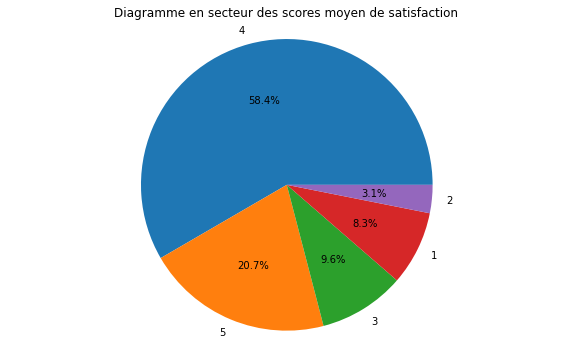

In [47]:
x = np.round(data.mean_review_score).astype(int)

plt.figure(figsize=(10, 6))
plt.pie(x.value_counts(), labels=x.unique(), autopct='%1.1f%%')
plt.axis('equal')
plt.title('Diagramme en secteur des scores moyen de satisfaction')
plt.show()

Il ya une majorité de bonnes notes.

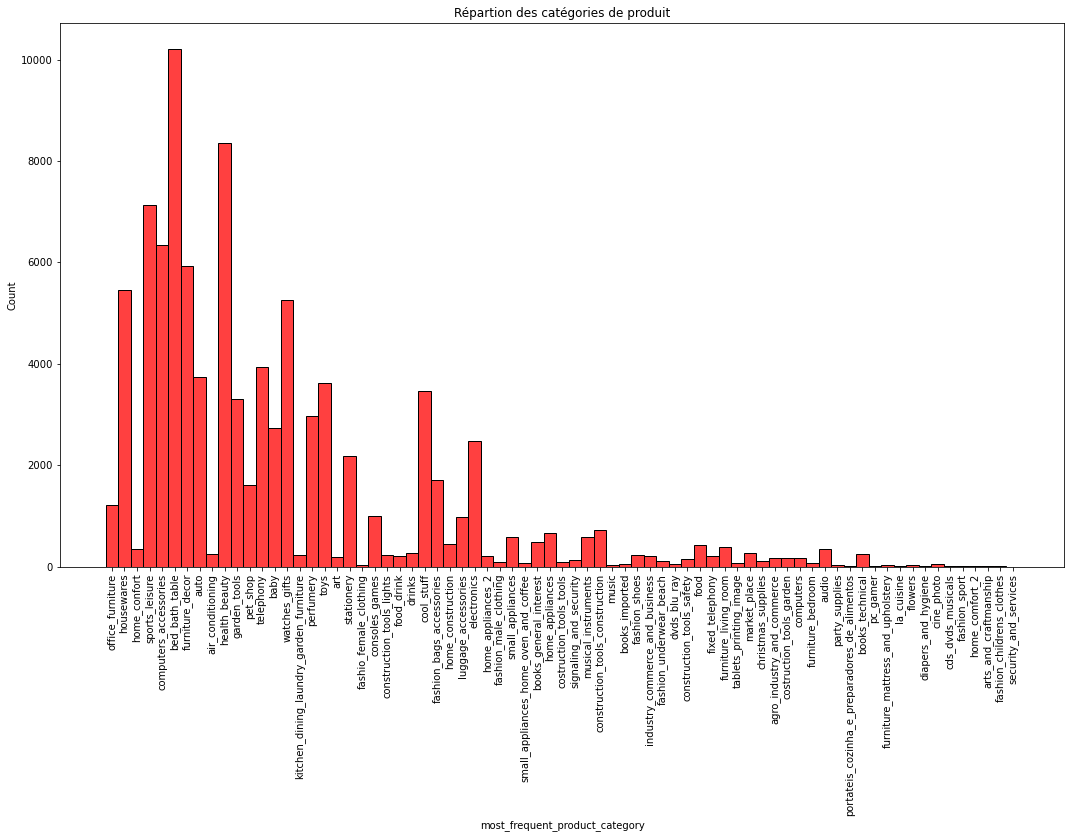

In [48]:
plt.figure(figsize=(18, 10))
sns.histplot(x='most_frequent_product_category', data=data, color='red')
plt.xticks(rotation=90)
plt.title('Répartion des catégories de produit')
plt.show()

<Figure size 720x432 with 0 Axes>

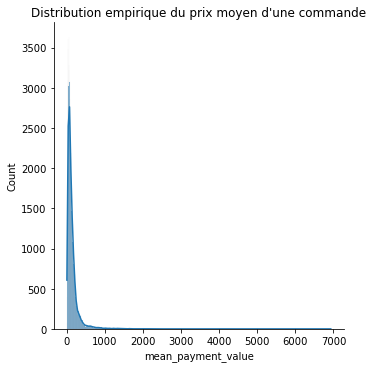

In [49]:
plt.figure(figsize=(10,6))
sns.displot(data['mean_payment_value'], kde=True)
plt.title("Distribution empirique du prix moyen d'une commande")
plt.show()

<Figure size 720x432 with 0 Axes>

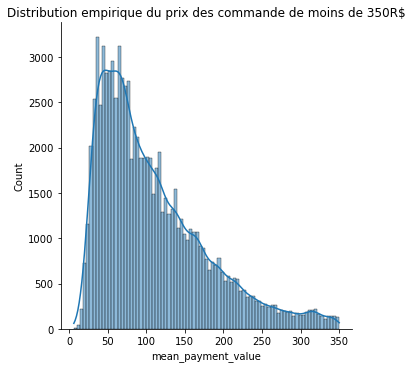

In [50]:
plt.figure(figsize=(10,6))
sns.displot(data.loc[data['mean_payment_value']<350, 'mean_payment_value'], kde=True)
plt.title("Distribution empirique du prix des commande de moins de 350R$")
plt.show()

## <a name="C15">5.2: Analyse bivariée</a>
Essayons maintenat de croiser les variables deux à deux.

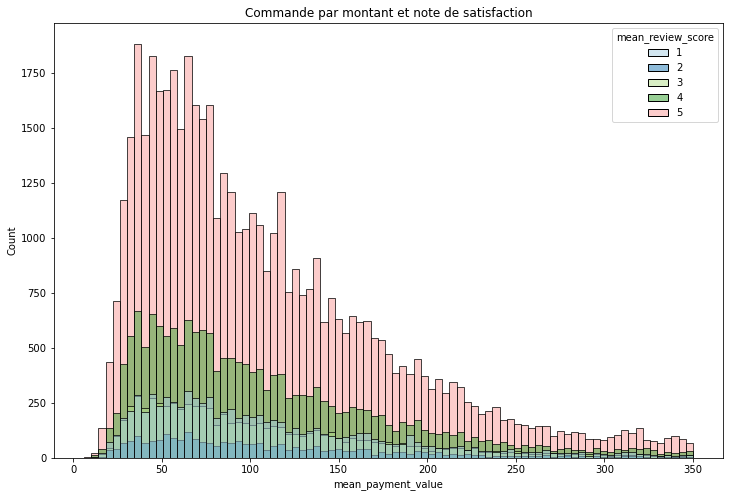

In [51]:
note = np.round(data.mean_review_score).astype(int)
x = data.loc[data['mean_payment_value']<350, 'mean_payment_value']

plt.figure(figsize=(12, 8))
sns.histplot(x=x, hue=note, palette='Paired')
plt.title('Commande par montant et note de satisfaction')
plt.show()

Les proportions de clients satisfaits et insatisfaits restent relativement stables quelque soit le montant de la commande.

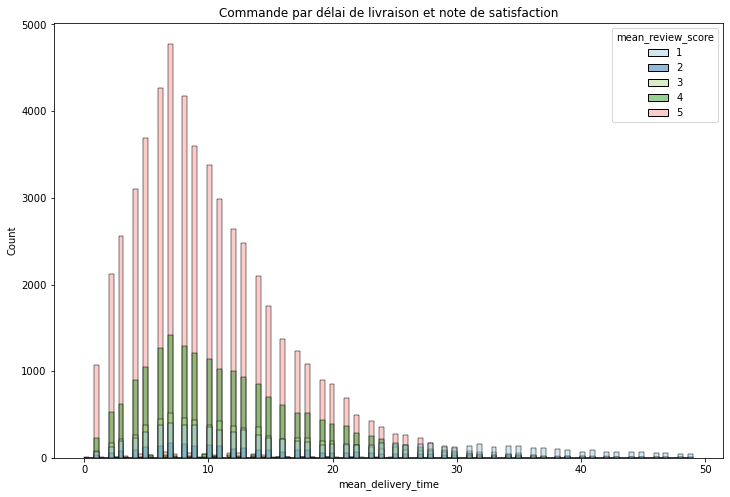

In [52]:
note = np.round(data.mean_review_score).astype(int)
x = data.loc[data['mean_delivery_time']<50, 'mean_delivery_time']

plt.figure(figsize=(12, 8))
sns.histplot(x=x, hue=note, palette='Paired')
plt.title('Commande par délai de livraison et note de satisfaction')
plt.show()

La proportion de clients insatisfaits augmente lorsque les délais de livraison sont trop longs. 

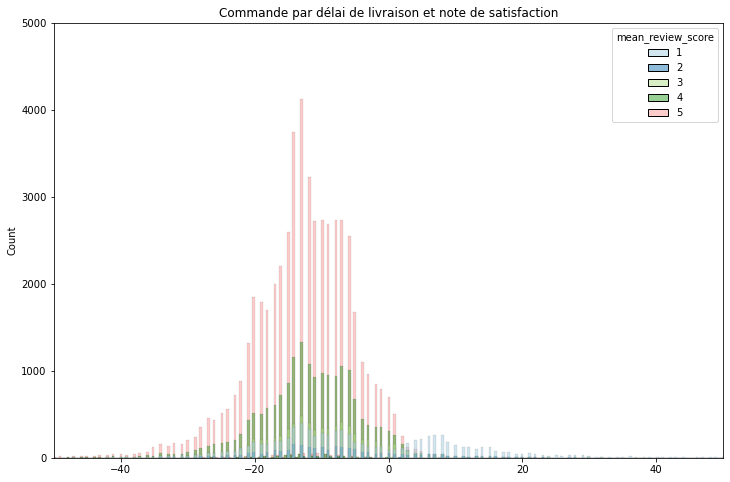

In [53]:
note = np.round(data.mean_review_score).astype(int)
x = data['mean_delivery_time'] - data['mean_estimated_delivery_time']

plt.figure(figsize=(12, 8))
sns.histplot(x=x, hue=note, palette='Paired')
plt.title('Commande par délai de livraison et note de satisfaction')
plt.axis([-50, 50, 0, 5000])
plt.show()

Plus précisément, l'insatisfaction augmente lorsque le délai de livraison dépasse le délai de livraison estimé.

<AxesSubplot:>

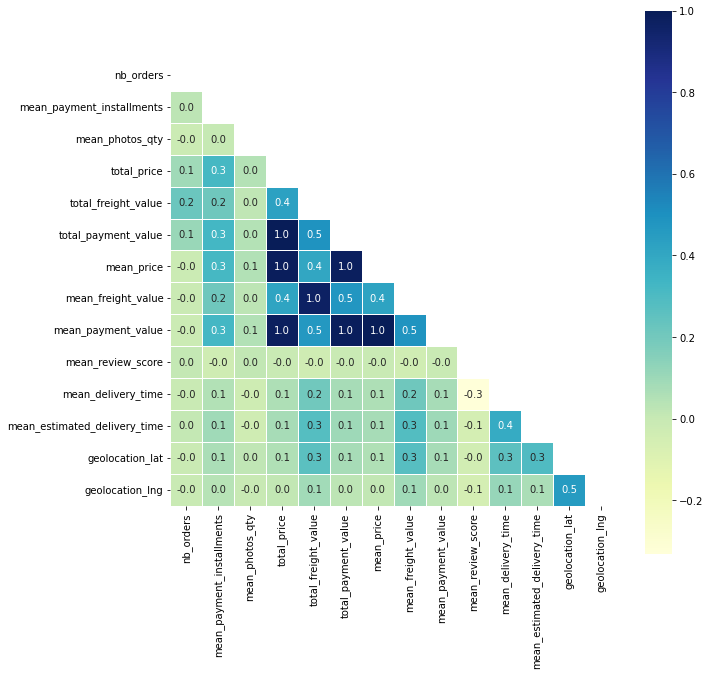

In [54]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10, 10))
plt.xticks(rotation=45)
sns.heatmap(corr, annot=True, cmap='YlGnBu', mask=mask, fmt='.1f', linewidths=.5, square=True, vmax=1)

Les fortes corrélations entre prix moyen et prix total viennent du fait que 97% des clients n'ont effectué qu'un seule commande et que par conséquent le prix moyen est égal au prix total. On va retirer ces variables pour éviter la redondance d'information et simplifier les modèles par la suite. 

In [55]:
listeVar = ['total_price', 'total_freight_value', 'total_payment_value', 'mean_price', 'mean_freight_value', 
            'mean_estimated_delivery_time']

data.drop(listeVar, axis=1, inplace=True)
data.head(2)

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,last_order_purchase_timestamp,most_frequent_product_category,geolocation_lat,geolocation_lng
customer_unique_id,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1,2.0,1.0,146.87,4.0,8.0,2017-05-16 15:05:35,office_furniture,-20.509897,-47.397866
290c77bc529b7ac935b93aa66c333dc3,1,8.0,3.0,335.48,5.0,16.0,2018-01-12 20:48:24,housewares,-23.726853,-46.545746


## <a name="C16">5.3: Réduction dimentionnelle</a>
Pour tenter d'améliorer nos modèles de clustering, on va récupérér les variables quantitatives non corrélées et réaliser une réduction dimensionelle afin de visualiser les données et peut-être distinguer différents groupes d'utilisateurs.

In [56]:
listeVar = ['last_order_purchase_timestamp', 'most_frequent_product_category']

dataQuanti = data.drop(listeVar, axis=1)
dataQuanti.head(2)

,nb_orders,mean_payment_installments,mean_photos_qty,mean_payment_value,mean_review_score,mean_delivery_time,geolocation_lat,geolocation_lng
customer_unique_id,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1,2.0,1.0,146.87,4.0,8.0,-20.509897,-47.397866
290c77bc529b7ac935b93aa66c333dc3,1,8.0,3.0,335.48,5.0,16.0,-23.726853,-46.545746


In [57]:
#On commence par standardiser les variables
std_scale = StandardScaler().fit(dataQuanti)
dataQuanti_scaled = std_scale.transform(dataQuanti)

In [58]:
#On calcule les composantes principales
pca = PCA(n_components=2)
pca.fit(dataQuanti_scaled)

#Pourcentage de variance expliquée
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.21259121 0.16015863]
0.37274984218648277


La première composante explique à elle seule 21% de la variance observée dans les données et la seconde 16%. </br>
Pour mieux comprendre ce que capture ces composantes principales, on peut afficher la contribution de chaque variable initiale aux nouvelles composantes.

(-0.7, 0.7)

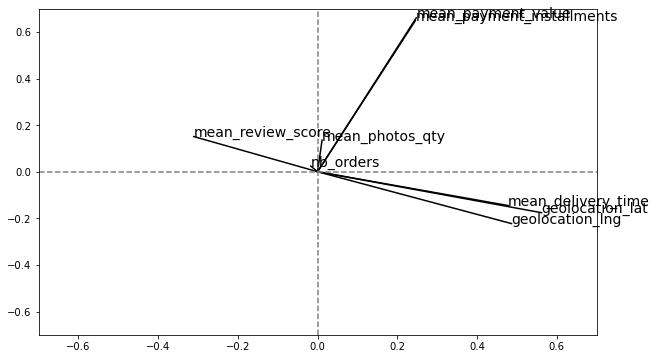

In [59]:
pcs = pca.components_

plt.figure(figsize=(10,6))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, dataQuanti.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

Les principales variables qui contribuent au premier axe sont les variables liées aux délai de livraison et à la localisation du client.</br>
Le nombre moyen de paiements et la valeur moyenne d'un panier ont une contribution positive à la deuxième composante.</br>

Nous pouvons représenter chaque client selon ces deux dimensions uniquement, et colorer chacun des points correspondant en fonction du score moyen de satisfaction d'une commande.

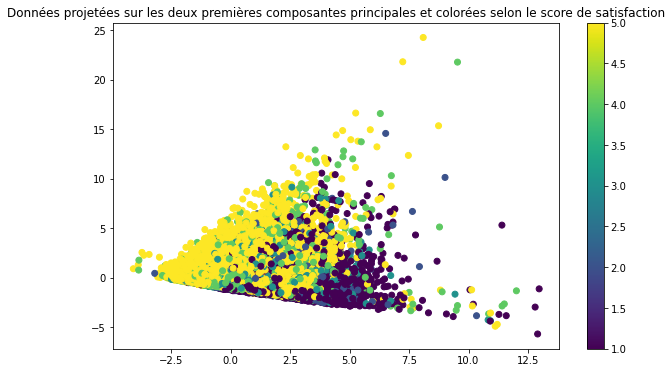

In [60]:
# projetion sur les composantes principales
dataQuanti_projected = pca.transform(dataQuanti_scaled)

# afficher chaque observation
plt.figure(figsize=(10,6))
plt.scatter(dataQuanti_projected[:, 0], dataQuanti_projected[:, 1],
    # colorer en utilisant la variable 'mean_review_score'
    c=data.get('mean_review_score'))

plt.title("Données projetées sur les deux premières composantes principales et colorées selon le score de satisfaction")
plt.colorbar()

On retrouve l'idée vue plus haut que le score de satisfaction a tendance à diminuer lorsque le temps de livraison augmente. </br>
On peut également visualiser notre dataset à l'aide de la méthode t-SNE pour essayer de distinguer différents clusters.

In [61]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(dataQuanti_projected)

C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\vbour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:title={'center':'T-SNE'}>

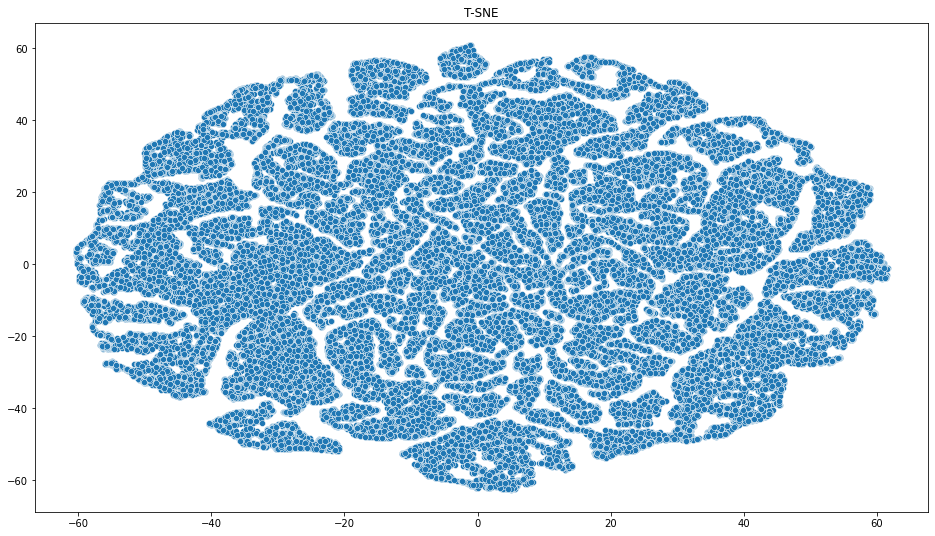

In [62]:
plt.figure(figsize=(16,9))
plt.title('T-SNE')
sns.scatterplot(x=T[:,0], y=T[:,1])

# <a name="C17">Partie 6: Exportation des jeux de données</a>
On peut à présent sauvegarder et exporter nos jeux de données pour la prochaine partie de modélisation.

In [63]:
dataPCA = pd.DataFrame(dataQuanti_projected, index=data.index)
dataPCA.head()

,0,1
customer_unique_id,,
861eff4711a542e4b93843c6dd7febb0,-0.332957,-0.230871
290c77bc529b7ac935b93aa66c333dc3,0.399906,2.050465
060e732b5b29e8181a18229c7b0b2b5e,0.580588,0.908309
259dac757896d24d7702b9acbbff3f3c,-0.487671,-0.329447
345ecd01c38d18a9036ed96c73b8d066,0.033916,1.702346


In [64]:
data.to_csv('dataNettoye.csv', sep = ',', encoding='utf_8', index=False)
dataPCA.to_csv('dataNettoyePCA.csv', sep=',', encoding='utf_8', index=False)